Pau has produced MC samples of $^{214}\text{Bi}$ decays in different volumes of the detector.
<br>
We are interested in:
- How many electrons coming from the $^{214}\text{Bi}$ @ cathode end up being fiducials.
- Energy specturm of fiducial electrons induced by $^{214}\text{Bi}$
<!-- end of the list -->
This notebook has five main parts:
- In _Preliminary_ you configure the type of analysis and its corresponding parameters.
- A _Validation_ Zone_ where all the interesting cuts are inspected in detail.
- All the processing process of an entire set of MCs is applied in _Processing_. Recently we use the processing functions from low-background analysis.
- In _Selection_, we apply the Trigger2 cut and detector region tagging.
- _Plots_ is used for paper purposes.
- In _ROI Analysis_ we compute the important numbers of background index.

__IMPORTANT__: Define in _Preliminary_ all the configuration needed for the use of this notebook or the name of H5 file you will use from _Selection_.

In [1]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis')

from libs import bckg_functions as bf
from libs import crudo
from libs import fit_functions as ff
from libs import plotting_tools as pt

from datetime import datetime
import glob
from invisible_cities.reco.corrections import read_maps
from invisible_cities.reco.corrections import apply_all_correction
from invisible_cities.types.symbols    import NormStrategy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import scipy

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preliminary

In [2]:
# ----- Type of Analysis ----- #
ANALYSIS_TYPE = 'All'                       # Options: 'All', 'Cathode'
DATE = datetime.now().strftime('%d%m%Y')        # Current Date
# DATE = '23092025'                             # Specific Date

# Selected MC dictionary
if ANALYSIS_TYPE == 'All': 
    RUN_TIME = 315360000    # Simulated exposure (10 years) in [s]
elif ANALYSIS_TYPE == 'Cathode':
    RUN_TIME = 315360       # Simulated exposure (0.01 year) in [s]

In [3]:
# --------------------------------------------
# 1. MC DIRECTORIES, PATHS, KEYS AND FILENAMES
# --------------------------------------------
MC_PATHS = []
if ANALYSIS_TYPE == 'All':

    MC_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_09_00/Bi214/'
    # Get all subfolders in MC_DIR
    VOLUMES = [folder for folder in os.listdir(MC_DIR) if os.path.isdir(os.path.join(MC_DIR, folder)) and folder != 'CATHODE_SURF']
    for volume in sorted(VOLUMES):
        # Get all sophronia files in the volume subfolder
        sophronia_files = sorted(glob.glob(os.path.join(MC_DIR, volume, 'sophronia', '*.sophronia.h5')))
        # print(f"  Found {len(sophronia_files)} sophronia files in {volume}")
        if sophronia_files:
            MC_PATHS.extend(sophronia_files)
        else:
            print(f"No sophronia files found in {volume}")
    # Sort the final list of paths
    MC_PATHS = sorted(MC_PATHS)
    print(f"Total sophronia files to process: {len(MC_PATHS)}")

elif ANALYSIS_TYPE == 'Cathode':

    MC_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_09_00/Bi214/CATHODE_SURF/sophronia/'
    MC_PATHS = sorted(glob.glob(MC_DIR + '*.sophronia.h5'))
    print(f"Total sophronia files to process: {len(MC_PATHS)}")

else:
    raise ValueError("Invalid ANALYSIS_TYPE. Choose 'All' or 'Cathode'.")

# KEYS
NEXUS_KEY = '/MC/configuration'
DORO_KEY = '/DST/Events'
SOPH_KEY = '/RECO/Events'

# COLIUMNS TO USE
doro_columns = ['event', 'time', 'nS1', 'nS2', 'S1h', 'S1e', 'S2e', 'S2q', 'DT', 'X', 'Y', 'Z']
soph_columns = ['event', 'time', 'npeak', 'X', 'Xpeak', 'Y', 'Z', 'Q', 'Ec']

# OUTPUT
OUTPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/'
OUTPUT_H5  = 'processed_MC_background_' + ANALYSIS_TYPE + '_' + DATE + '.h5'
print(f"Output will be saved to: {os.path.join(OUTPUT_DIR, OUTPUT_H5)}")

# ----------------------
# 2. ANALYSIS PARAMETERS
# ----------------------
V_DRIFT = 0.865     # Drift velocity in [mm/μs]

# --- S1 Signal Cuts ---
# Po-like events are filtered using: S1h >= m * S1e + b
M_NOPOLIKE = 0.17
B_NOPOLIKE = -56

# --- S1e Correction ---
DT_STOP = 1372.2543          # Cathode temporal position in [μs]
CV_FIT  = [0.57, 796.53]     # Fit values for S1e correction vs DT

# --- Alpha/Electron Separation Cut ---
# Events with total corrected energy above this threshold are classified as alphas.
ENERGY_THRESHOLD_PE = 7.5e5       # in [PE]

# --- HE Scale Correction ---
M_HE_SCALE = 4.80e-06
B_HE_SCALE = 0.0094
ENERGY_THRESHOLD_MEV = M_HE_SCALE * ENERGY_THRESHOLD_PE + B_HE_SCALE   # in [MeV]

# --- Hits Clusterizer Configuration ---
CLUSTER_CONFIG = {"eps": 3, "min_samples": 5}

# --- Trigger 2 Efficiency Cut ---
# Events with event-level energy below this are removed to account for trigger efficiency.
TRG2_THRESHOLD = 0.5         # in [MeV]

# -------------------
# 3. DETECTOR REGIONS
# -------------------
# Geometric boundaries for event classification.
Z_LOW = 40          # in [mm]
Z_UP  = 1147        # in [mm]
R_UP  = 451.65      # in [mm]

Total sophronia files to process: 15503
Output will be saved to: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/processed_MC_background_All_01122025.h5


# Validation Zone

We first explore the content of the _dorothea_ and _sophronia_ dataframes.

## Reconstruction

In [33]:
# Initialize empty lists to store the dataframes
run_dst  = []
run_reco = []
doro_counter, soph_counter = 0, 0

# ----- File Loop ----- #
for h5_path in MC_PATHS[:50]:

    # print(f"--- Processing {h5_path} ---")

    try:
        # ----- Dorothea ----- #
        dst_df = pd.read_hdf(h5_path, key=DORO_KEY)
        # dst_df = dst_df.loc[:, doro_columns]          # Activate this when you are completely sure!
        doro_counter += dst_df['event'].nunique()
        run_dst.append(dst_df)

        # ----- Sophronia ----- #
        reco_df = pd.read_hdf(h5_path, key=SOPH_KEY)
        # reco_df = reco_df.loc[:, soph_columns]
        soph_counter += reco_df['event'].nunique()
        run_reco.append(reco_df)

    except KeyError as e:
        print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

# ----- Concatenate Data ----- #
test_doro = pd.DataFrame()
test_soph = pd.DataFrame()

if run_dst:
    test_doro = pd.concat(run_dst, ignore_index=True)

if run_reco:
    test_soph = pd.concat(run_reco, ignore_index=True)

# ----- Print Summary ----- #
print(f"--- You have loaded {len(run_dst)} files ---")
print(f"Dorothea events  = {doro_counter}")
print(f"Sophronia events = {soph_counter}")

--- You have loaded 50 files ---
Dorothea events  = 7509
Sophronia events = 7508


#### Why are those numbers different?

If the $S2$ signal is not strong enough to activate the SiPMs (lower charge than the threshold), a false hit is created with negative values in $XYZ$ but the energy of the corresponding slice is stored.
<br>
__Hyp:__ Sophronia ignores pairs with _weak_ $S2$ signals.

In [34]:
# Dorothea
weak_S2_ids = test_doro.loc[test_doro['S2q'] < 0, 'event'].unique()     # List of events with weaks S2

# Sophronia
weak_S2_in_soph_ids = []

for evt_id in weak_S2_ids:

    # Dorothea
    df_doro = test_doro[test_doro['event'] == evt_id]
    nS2_doro = df_doro['s2_peak'].nunique()

    # Sophronia
    df_soph = test_soph[test_soph['event'] == evt_id]
    nS2_soph = df_soph['npeak'].nunique()

    if nS2_doro == nS2_soph:
        weak_S2_in_soph_ids.append(evt_id)
    else:
        continue

print(f"From {len(weak_S2_ids)} events with weak S2 in Dorothea, {len(weak_S2_in_soph_ids)} have the same number of S2 peaks in Sophronia.")

From 5 events with weak S2 in Dorothea, 0 have the same number of S2 peaks in Sophronia.


Most of the pairs with $S2$ weak are ignored in Sophronia.
<br>
If Sophronia ignored all the weak $S2$, do not follow these cells.

In [22]:
hits_S2_weak = []
hits_S2_norm = []

for evt_id in weak_S2_in_soph_ids:

    print(f"--- Event {evt_id}: ---")

    # Sophronia
    df_soph_npeak = test_soph[test_soph['event'] == evt_id].groupby('npeak')

    for npeak_id, group in df_soph_npeak:

        if (group['Xpeak'] < -5000).any():  # These are the weak S2 peaks
            hits_S2_weak.append(len(group))
            print(f"  Peak {npeak_id} is weak and has {len(group)} hits.")
        else:
            hits_S2_norm.append(len(group))

In [25]:
# Global
min_hits = min(min(hits_S2_weak), min(hits_S2_norm))
max_hits = max(max(hits_S2_weak), max(hits_S2_norm))
bins = np.arange(min_hits, max_hits + 2)

# Histogram for hits_S2_weak
hits_weak_counts, hits_weak_edges = np.histogram(hits_S2_weak, bins=bins)

# Histogram for hits_S2_norm
hits_norm_counts, hits_norm_edges = np.histogram(hits_S2_norm, bins=bins)

# Plotting
plt.figure(figsize=(8, 6))
plt.stairs(hits_weak_counts, hits_weak_edges, fill=False, lw=1.5, ec='blue', label='Weak S2 Peaks')
plt.stairs(hits_norm_counts, hits_norm_edges, fill=False, lw=1.5, ec='green', label='Normal S2 Peaks')

# Styling
plt.xlabel('Number of Hits')
# plt.xlim(0, 100)
plt.ylabel('Counts')
plt.title('Hits Multiplicity per S2 Peak')
plt.legend()

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

ValueError: min() arg is an empty sequence

I will ignore all these weak $S2$ peaks.

## Cleaning Part

In [35]:
# Remove weak S2 peaks in Dorothea and Sophronia
test_doro = test_doro[test_doro['S2q'] >= 0].copy()
test_soph = test_soph[test_soph['Xpeak'] >= -5000].copy()

print(f"After removing weak S2 peaks: {test_soph['event'].nunique()} events ({test_soph['event'].nunique()/soph_counter:.2%})")

# Set hits with NaN or negative energy to 0
test_soph['Ec'] = np.where(
                                pd.notna(test_soph['Ec']) & (test_soph['Ec'] > 0),        # Condition
                                test_soph['Ec'],                                          # Value if condition is True
                                0                                                         # Value if condition is False   
)

# Update dataframes
good_evts_01 = test_soph['event'].unique()
test_doro = test_doro[test_doro['event'].isin(good_evts_01)].copy()     # Keep only events with good sophronia info

print(f"After set hits with NaN or negative energy to 0: {len(good_evts_01)} events ({len(good_evts_01)/soph_counter:.2%})")

After removing weak S2 peaks: 7508 events (100.00%)
After set hits with NaN or negative energy to 0: 7508 events (100.00%)


## $S1$ Signal

#### How does the $S1$ behave?

In [37]:
test_doro['nS1'].value_counts()

1    11022
0      325
2       78
Name: nS1, dtype: int64

~~I would not expect events with $0\,S1$ (anode-like), let's see some of them.~~
<br>
Well, we can have anode events.

In [38]:
evts_NO_S1 = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique()
print(len(evts_NO_S1))

242


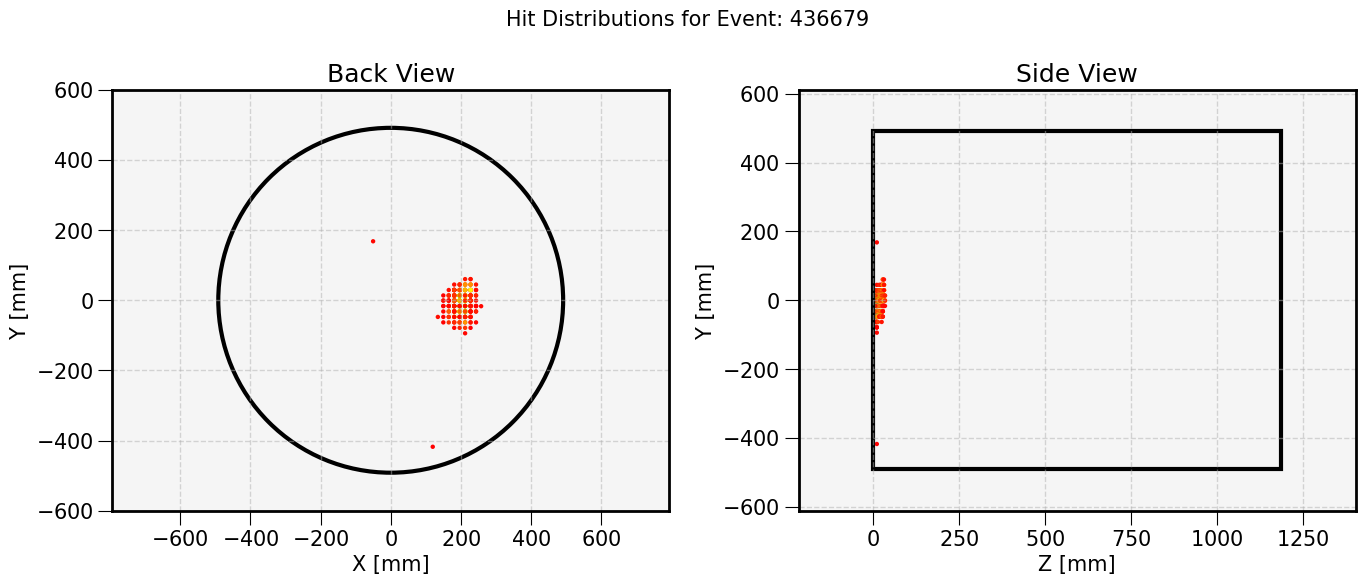

In [45]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(evts_NO_S1))

But yeah, they look like events near to the anode, in particular, coming from the edges of the detector.

In [46]:
# ----- nS1 = 1 ----- #
data_S1 = test_doro[test_doro['nS1'] == 1].copy()

# ----- nS1 = 1 & nS2 = 1 ----- #
data_S1_S2 = data_S1[data_S1['nS2'] == 1].copy()

# ----- S1e Correction ----- #
data_S1    = crudo.correct_S1e(data_S1,    CV_FIT, DT_STOP, output_column='S1e_corr')
data_S1_S2 = crudo.correct_S1e(data_S1_S2, CV_FIT, DT_STOP, output_column='S1e_corr')

Is the $S1$ energy corrected?

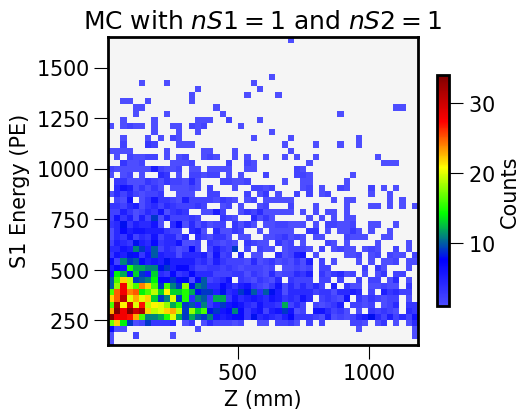

In [67]:
# Global
n_bins = 50
E1_max = 3e3; Z_max = pt.N100_hei

# Variables
E1 = data_S1_S2['S1e_corr']
Z  = data_S1_S2['Z']

# Binning
E1_bins = np.linspace(E1.min(), E1.max(), n_bins)
Z_bins  = np.linspace(0, Z_max, n_bins)

# 2D histogram
S1e_Z_map, ex, ey = np.histogram2d(Z, E1, bins=n_bins)
S1e_Z_map         = np.ma.masked_where(S1e_Z_map==0, S1e_Z_map)     # Zero values masked

# Plotting
plt.figure(figsize=(5, 4))
plt.pcolormesh(ex, ey, S1e_Z_map.T, cmap=pt.custom_hsv, shading='auto')

# Sytling
cbar = plt.colorbar(label='Counts', shrink=0.75)
plt.xlabel('Z (mm)')
plt.ylabel('S1 Energy (PE)')
plt.title(r'MC with $nS1 = 1$ and $nS2 = 1$')
plt.gca().set_facecolor("whitesmoke")
plt.show()

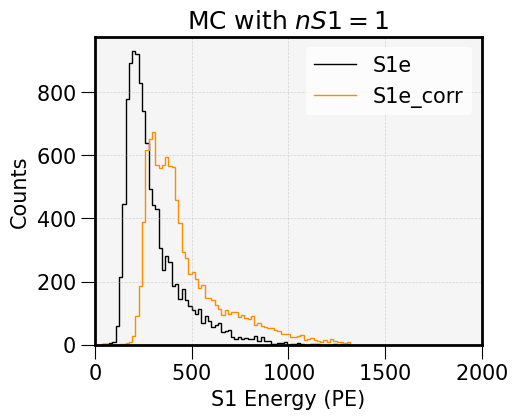

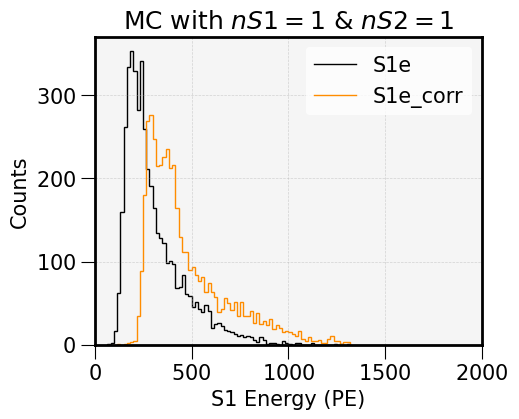

In [ ]:
# Global
n_bins = 75
E1_max = 2e3
titles = [r'MC with $nS1 = 1$', r'MC with $nS1 = 1$ & $nS2 = 1$']

for i, df in enumerate([data_S1, data_S1_S2]):

    plt.figure(figsize=(5, 4))
    plt.title(titles[i])
    _, E1_edges = np.histogram(df['S1e'], bins=n_bins)

    for j, col in enumerate(['S1e', 'S1e_corr']):

        # Variables
        E1 = df[col]

        # Histogram
        E1_counts, _ = np.histogram(E1, bins=E1_edges)

        # ----- Plotting ----- #
        plt.stairs(E1_counts, E1_edges, label=f'{col}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j*2 % len(pt.hist_colors)])

    # Styling
    plt.xlabel('S1 Energy (PE)')
    plt.xlim(0, E1_max)
    plt.ylabel('Counts')
    plt.legend()

    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

#### Is it important a NO-Polike cut?

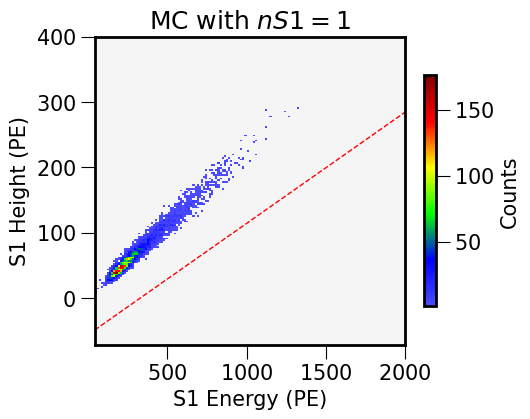

In [69]:
# Global
n_bins = 150
H1_max = 400; E1_max = 2e3

# Variables
H1 = data_S1['S1h']
E1 = data_S1['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1_max, n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked

# Plotting
plt.figure(figsize=(5, 4))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, M_NOPOLIKE, B_NOPOLIKE), c='red', ls='--', lw=1)        # Limit line

# Styling
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('S1 Energy (PE)')
plt.ylabel('S1 Height (PE)')
plt.title(r'MC with $nS1 = 1$')
plt.gca().set_facecolor("whitesmoke")
plt.show()

Nope, it is completely unnecesary.

### Execution

In [70]:
print("After S1 signal cuts:")

# ----- Counters for Efficiencies ----- #
evt_prior = test_soph['event'].nunique()
nS1_0_evt_ids = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique();   print(f"    nS1 = 0: {len(nS1_0_evt_ids)} events ({len(nS1_0_evt_ids)/evt_prior:.2%})")
nS1_1_evt_ids = test_doro.loc[test_doro['nS1'] == 1, 'event'].unique();   print(f"    nS1 = 1: {len(nS1_1_evt_ids)} events ({len(nS1_1_evt_ids)/evt_prior:.2%})")

# ----- S1 Signal ----- #
test_doro = test_doro[(test_doro['nS1'] == 0) | (test_doro['nS1'] == 1)].copy()

# ----- S1e Correction ----- #
test_doro = crudo.correct_S1e(test_doro, CV_FIT, DT_STOP, output_column='S1e_corr')    # I'll work with this corrected S1 energy
# Check if the correction was applied
if 'S1e_corr' not in test_doro.columns:
    print(f"Error: S1e correction not applied! Skipping...")

# Update dataframes
good_evts_02 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evts_02)].copy()

print(f"{len(good_evts_02)} events ({len(good_evts_02)/evt_prior:.2%})")

After S1 signal cuts:
    nS1 = 0: 242 events (3.22%)
    nS1 = 1: 7248 events (96.54%)
7490 events (99.76%)


## $S2$ Signal

#### How does it behave the $S2$ energy?

In [71]:
# ----- nS2 = 1 ----- #
data_S2 = test_doro[test_doro['nS2'] == 1].copy()

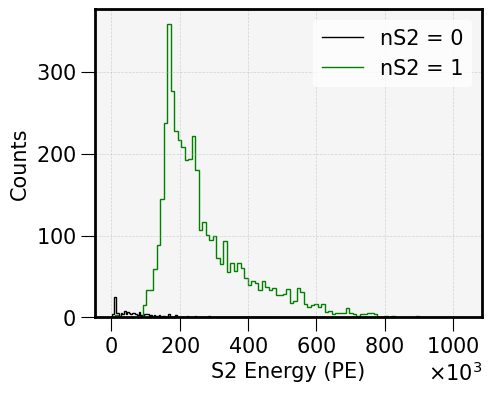

In [ ]:
# Global
n_bins = 100
E2_max = 2000e3

plt.figure(figsize=(5, 4))

for i, label in enumerate(['nS2 = 0', 'nS2 = 1']):
    
    if label == 'nS2 = 0':
        data = data_S2[data_S2['nS1'] == 0].copy()
        E2 = data['S2e']
    else:
        data = data_S2[data_S2['nS1'] == 1].copy()
        E2 = data['S2e']

    # Histogram
    E2_counts, E2_edges = np.histogram(E2, bins=n_bins)

    # Plotting
    plt.stairs(E2_counts, E2_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[4*i % len(pt.hist_colors)])

# Styling
plt.xlabel('S2 Energy (PE)')
# plt.xlim(0, E2_max)
plt.ylabel('Counts')
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend()

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

#### __THESE COMMENTS ARE VALID JUST FOR CATHODE MC FILES__

We know that alpha population is around $1000\times10^{3}\,\text{pe}$.
<br>
The $nS2 = 1$ cut remove almost all the aplha contribution (BiPo coincidence!).
<br>
In any case, let's check that population of events around $3000\times10^{3}\,\text{pe}$.

In [73]:
pop_3000_ids = data_S2.loc[data_S2['S2e'] >= 3000e3, 'event'].unique()
print(len(pop_3000_ids))

0


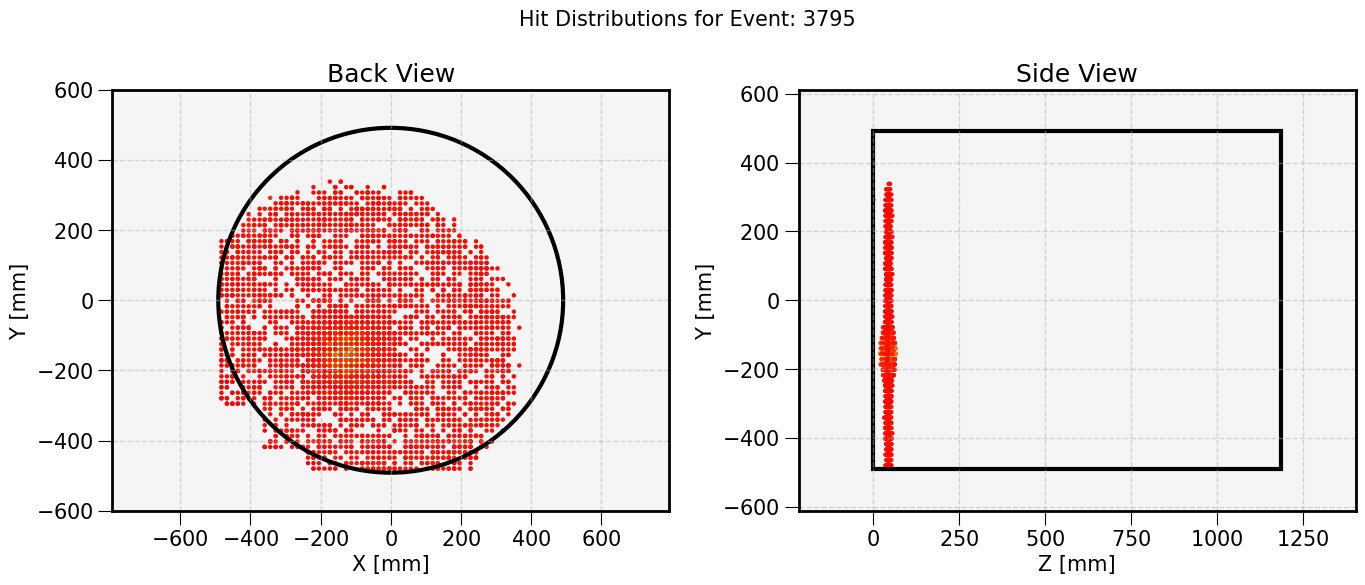

In [35]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_3000_ids))

This population seems to be alphas but with so many hits! __Why?__

In [36]:
pop_std_ids = data_S2.loc[data_S2['S2e'] < 1500e3, 'event'].unique()
print(len(pop_std_ids))

926


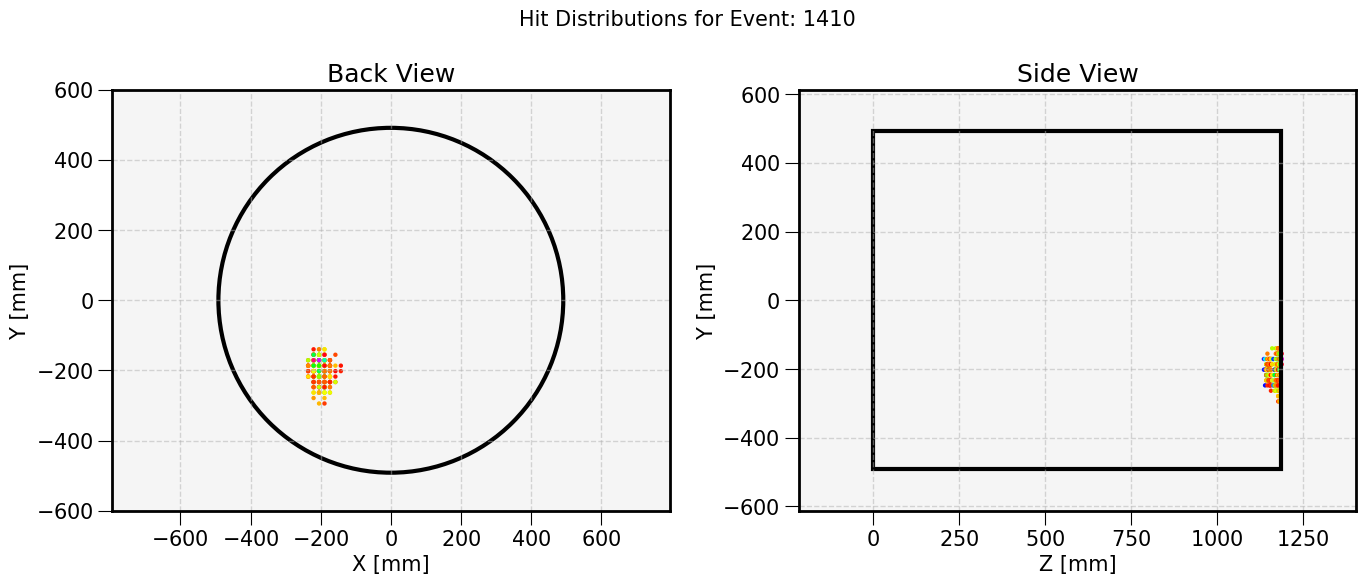

In [37]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_std_ids))

Here I notice more events "well-reconstructed", but we still need to distinguish between alphas and electrons.
<br>
First, we apply the $nS2 = 1$ cut.
<br>
__Notice the low efficieny, we are killing the BiPo coincidence!__

### Execution

In [74]:
# Event counter
evt_prior = test_soph['event'].nunique()

# ----- S2 Signal ----- #
test_doro = test_doro[test_doro['nS2'] == 1].copy()

# Update dataframes
good_evt_03 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evt_03)].copy()

print(f"After S2 signal cut: {len(good_evt_03)} events ({len(good_evt_03)/evt_prior:.2%})")

After S2 signal cut: 4684 events (62.54%)


## $\alpha$ and $e$ Populations

__NOTE:__ Just the cathode MC files include $\alpha$ population.

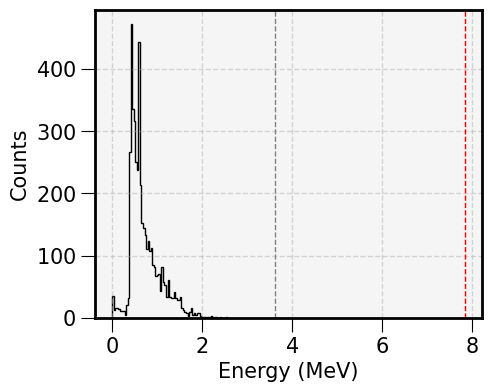

In [78]:
# Global
n_bins = 75

# Variables
E = test_soph.groupby('event')['Ec'].sum()

# Histogram
E_counts, E_edges = np.histogram(E, bins=n_bins)

# Plotting
plt.figure(figsize=(5, 4))
plt.stairs(E_counts, E_edges,
           fill=False, lw=1.0, ec='black')
    
# 214Po peak as reference!
x_Po = 7.83
plt.axvline(x=x_Po, color='red', ls='--', lw=1)
# plt.text(0.98*x_Po, 300, f'{x_Po} MeV', c='red', ha='right', va='bottom')

# Energy threshold
x_flag = ENERGY_THRESHOLD_MEV
plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
# plt.text(0.98*x_flag, 300, f'{x_flag:.2f} MeV', c='gray', ha='right', va='bottom')

# Styling
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

As alphas, we expect to have them around $7.83\,\text{MeV}$ (the Q value of $^{214}\text{Po}$).
<br>
I will use the same energy threshold to separate alphas and electrons (gray line).

In [79]:
# Event counter
evt_prior = test_soph['event'].nunique()

# Variables
evt_energy = test_soph.groupby('event')['Ec'].sum()

# Event IDs for alphas and electrons
elec_ids  = evt_energy[evt_energy <= ENERGY_THRESHOLD_MEV].index
alpha_ids = evt_energy[evt_energy >  ENERGY_THRESHOLD_MEV].index

# Update dataframes
test_doro = test_doro[test_doro['event'].isin(elec_ids)].copy()
test_soph = test_soph[test_soph['event'].isin(elec_ids)].copy() 
print(f"Electron candidates: {len(elec_ids)} events ({len(elec_ids)/evt_prior:.2%}) ")

Electron candidates: 4684 events (100.00%) 


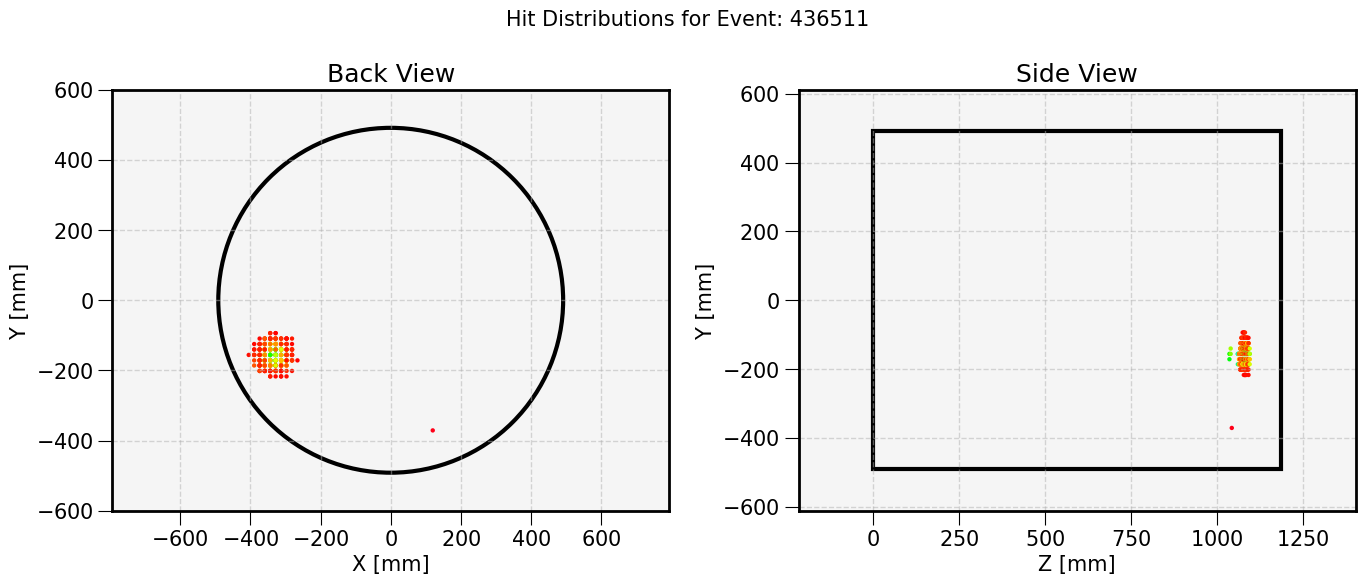

In [89]:
pt.event_display(test_soph, variable='Ec')

Max. Energy: 2.5634 MeV


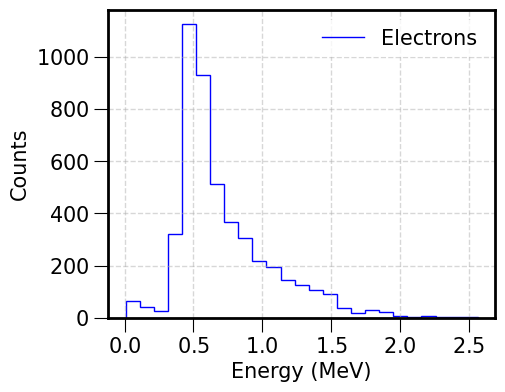

In [91]:
E_electron_evt = test_soph.groupby('event')['Ec'].sum()
print(f'Max. Energy: {E_electron_evt.max():.4f} MeV')

# Binning
E_electron, e_elec = np.histogram(E_electron_evt, bins=25)

plt.figure(figsize=(5, 4))
plt.stairs(E_electron, e_elec, fill=False, ec='blue', lw=1.0, label='Electrons')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

### Electron Clusters

In [109]:
cluster_tagger = crudo.hits_clusterizer(eps=3, min_samples=5)
hits_clustered_df = cluster_tagger(test_soph).loc[:, ['event', 'npeak', 'X', 'Y', 'Z', 'Ec', 'cluster']]

In [ ]:
events_with_secondary_tracks = hits_clustered_df.loc[
                                                        hits_clustered_df['cluster'] > 0,
                                                        'event'
                                                    ]

Check some events to see the result!

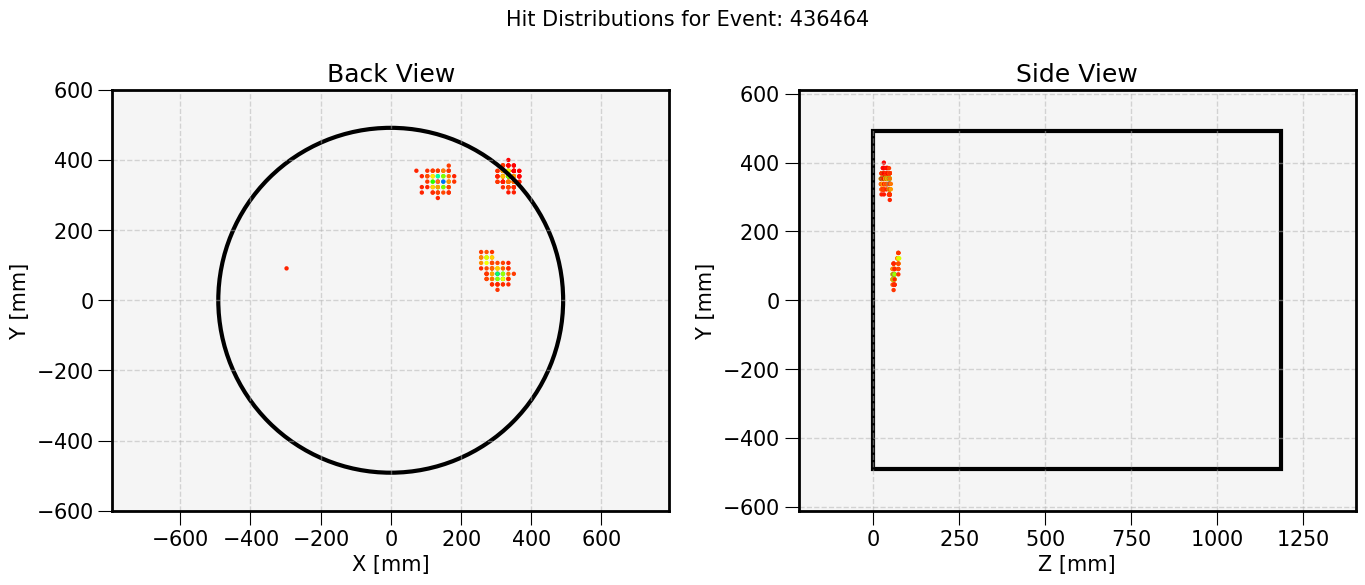

In [198]:
event_to_try = np.random.choice(events_with_secondary_tracks)
# event_to_try = 33
pt.event_display(hits_clustered_df, variable='Ec', event=event_to_try)

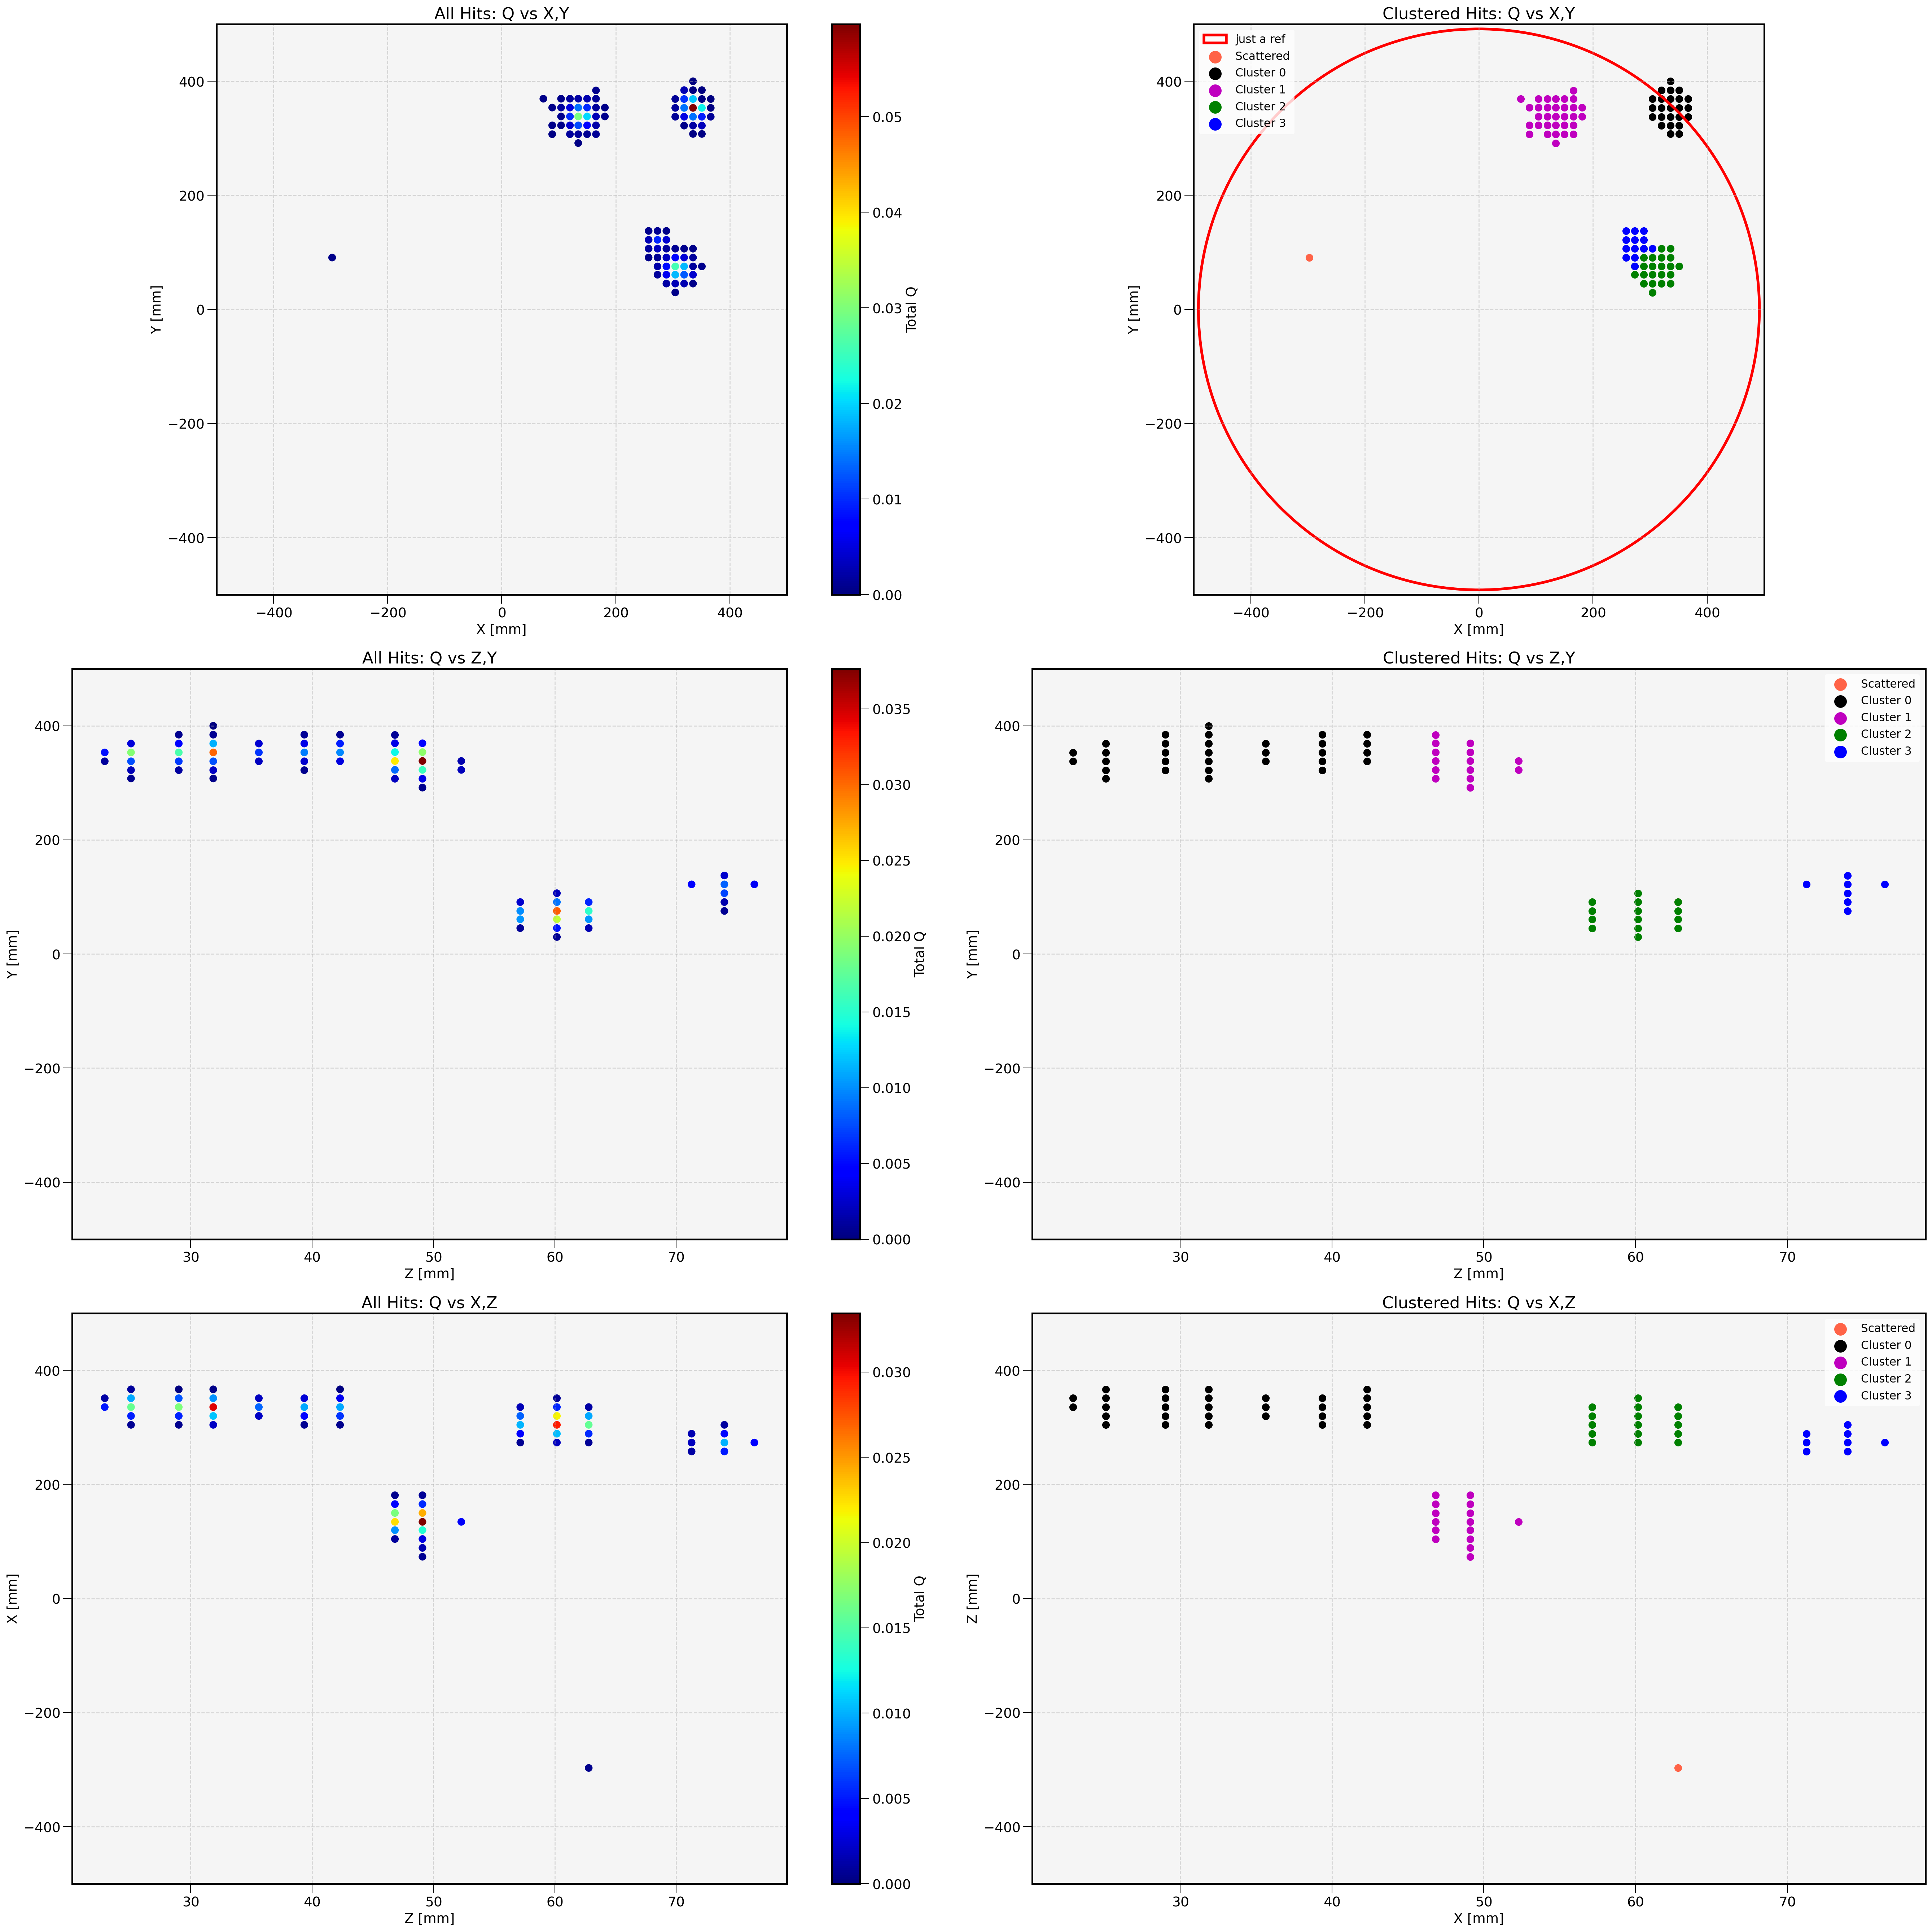

In [199]:
event_clustered = hits_clustered_df[hits_clustered_df['event'] == event_to_try]
pt.display_event_cluster(event_clustered, energy_column='Ec')

In [183]:
# If after remove tags -1 (noise) and 0 (main cluster) there are still clusters tag, then the event has NOT a single track
event_topology = hits_clustered_df.groupby(['event', 'npeak'])['cluster'].apply(
                    lambda clusters: 'yes' if not set(clusters.unique()) - {-1, 0} else 'no'
                )
# Let's rename the series for clarity
event_topology = event_topology.rename('single_track')

In [184]:
event_topology

event   npeak
2       0        yes
7       1        yes
9       0        yes
13      0        yes
14      0        yes
                ... 
545742  0        yes
545743  1        yes
545744  0        yes
545745  0        yes
545747  0        yes
Name: single_track, Length: 4684, dtype: object

# Processing

## Functions

In [4]:
# Helper function
def aggregate_to_event_level(df_soph: pd.DataFrame, df_doro: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates hit-level data to event-level summary data.
    Variation wrt low-background analysis.
    """
    if df_soph.empty:
        return pd.DataFrame()

    # ----- Dorothea Aggregation ----- #
    doro_agg_dict = {
                        'nS1': ('nS1', 'max'),
                        'nS2': ('nS2', 'max'),
                        'S1e': ('S1e', 'max'),
                        'S1e_corr': ('S1e_corr', 'max'),
                    }
    doro_agg_df = df_doro.groupby('event', as_index=False).agg(**doro_agg_dict)
    # ----- Sophronia Aggregation ----- #
    soph_agg_dict = {
                        'time': ('time', 'mean'),
                        'X_bary': ('X', lambda x: bf.weighted_avg(x, df_soph.loc[x.index, 'Ec'])),
                        'Y_bary': ('Y', lambda y: bf.weighted_avg(y, df_soph.loc[y.index, 'Ec'])),
                        'Z_bary': ('Z', lambda z: bf.weighted_avg(z, df_soph.loc[z.index, 'Ec'])),
                        'E_mev': ('Ec', 'sum'),
                        'Z_min': ('Z', 'min'),
                        'Z_max': ('Z', 'max'),
                        'R_max': ('X', lambda g: bf.R_max_func(df_soph.loc[g.index]))
                    }

    # Perform aggregation
    df_file = df_soph.groupby(['event', 'npeak'], as_index=False).agg(**soph_agg_dict)
    df_file = pd.merge(df_file, doro_agg_df, on='event', how='left')

    return df_file

# ----- Process Function ----- #

def process_mc_file(h5_path):
    """
    Processes a single Monte Carlo HDF5 file.
    Reads data, applies cuts, aggregates, and returns results.
    """
    h5_path = Path(h5_path)
    # print(f"→ Processing file: {h5_path}\n")

    # Event counters for this file
    counts = {
                'gen': 0, 'reco': 0, 'clean': 0,
                's1_cut': 0, 'ns1_zero': 0, 'ns1_one': 0,
                's2_cut': 0, 'electron': 0
    }

    # ----- Load Dataframes ----- #
    try:
        # Nexus
        df_nexus = pd.read_hdf(h5_path, key=NEXUS_KEY)
        gen_evts_series = df_nexus.loc[df_nexus['param_key'] == 'num_events', 'param_value']
        if not gen_evts_series.empty:
            counts['gen'] = int(gen_evts_series.values[0])      # Count of generated events
        # Dorothea
        df_dorothea = pd.read_hdf(h5_path, key=DORO_KEY).loc[:, doro_columns]
        # Sophronia
        df_sophronia = pd.read_hdf(h5_path, key=SOPH_KEY).loc[:, soph_columns]
        counts['reco'] = df_sophronia['event'].nunique()        # Count of reconstructed events
    except KeyError as e:
        print(f"Key {e} not found in {h5_path.name}. Skipping file.")
        return None
    
    # ----- Data Cleaning ----- #
    # Remove weak S2 peaks in Dorothea and Sophronia
    df_dorothea  = df_dorothea[df_dorothea['S2q'] >= 0].copy()
    df_sophronia = df_sophronia[df_sophronia['Xpeak'] >= -5000].copy()
    # Set hits with NaN or negative energy to 0
    df_sophronia['Ec'] = np.where(
                                    pd.notna(df_sophronia['Ec']) & (df_sophronia['Ec'] > 0),        # Condition
                                    df_sophronia['Ec'],                                             # Value if condition is True
                                    0                                                               # Value if condition is False   
                                  )
    # Update dataframes
    evts_after_clean = df_sophronia['event'].unique()
    df_dorothea = df_dorothea[df_dorothea['event'].isin(evts_after_clean)].copy()
    counts['clean'] = len(evts_after_clean)

    # ----- Basic Cuts & S1e Correction ----- #
    # nS1 <= 1 (NO-Polike)
    counts['ns1_zero'] = df_dorothea.loc[df_dorothea['nS1'] == 0, 'event'].nunique()
    counts['ns1_one']  = df_dorothea.loc[df_dorothea['nS1'] == 1, 'event'].nunique()
    s1_mask = (df_dorothea['nS1'] == 0) | (df_dorothea['nS1'] == 1)
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, cut_mask=s1_mask, df_for_mask=df_dorothea)
    counts['s1_cut'] = df_sophronia['event'].nunique()
    # nS2 = 1
    s2_mask = (df_dorothea['nS2'] == 1)
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, cut_mask=s2_mask, df_for_mask=df_dorothea)
    counts['s2_cut'] = df_sophronia['event'].nunique()
    # S1e Correction (NO mandatory)
    df_dorothea = crudo.correct_S1e(df_dorothea, CV_FIT, DT_STOP, output_column='S1e_corr')     # Based on alpha analysis

    # ----- Electron Candidates ----- #
    event_energy = df_sophronia.groupby('event')['Ec'].sum()
    elec_ids = event_energy[event_energy <= ENERGY_THRESHOLD_MEV].index     # Index in this group is event ID
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, event_ids=elec_ids)
    counts['electron'] = df_sophronia['event'].nunique()

    # If there is no data left after cuts, return empty dataframes
    if df_sophronia.empty:
        return {'processed_df': pd.DataFrame(), 'sophronia_df': pd.DataFrame(), 'counts': counts}

    # ----- Topology Information ----- #
    cluster_tagger = crudo.hits_clusterizer(**CLUSTER_CONFIG)
    df_sophronia = cluster_tagger(df_sophronia)
    events_with_secondary_tracks = df_sophronia.loc[ df_sophronia['cluster'] > 0, 'event'].unique()    
    
    # ----- Dataframe @ Event-Level ----- #
    df_event = aggregate_to_event_level(df_sophronia, df_dorothea)
    # Add topology info
    df_event['single_track'] = np.where(
                                            df_event['event'].isin(events_with_secondary_tracks),
                                            'no',
                                            'yes'
                                        )
    
    # ----- Monte Carlo Information ----- #
    isotope = h5_path.parts[-4]
    volume  = h5_path.parts[-3]
    df_event['isotope'] = isotope;      df_sophronia['isotope'] = isotope
    df_event['volume']  = volume;       df_sophronia['volume']  = volume

    return {'processed_df': df_event, 'sophronia_df': df_sophronia, 'counts': counts}

## Execution

In [5]:
# Event counters
Total_gen   = 0
Total_reco  = 0   
Total_clean = 0
Total_S1 = 0;      Total_nS1_one  = 0;     Total_nS1_zero  = 0
Total_S2 = 0
Total_electron = 0

# Store all the processed dfs
all_processed_dfs = []
all_sophronia_dfs = []

# ----- Parallel Processing ----- #
print(f"----- Processing {len(MC_PATHS)} files in parallel -----")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_mc_file)(h5_path) for h5_path in MC_PATHS
)
print("Processing complete.")

# ----- Collect Results ----- #
valid_results = [r for r in results if r is not None]       # Filter out None results
all_processed_dfs = [res['processed_df'] for res in valid_results if not res['processed_df'].empty]
all_sophronia_dfs = [res['sophronia_df'] for res in valid_results if not res['sophronia_df'].empty]

# ----- Concatenation ----- #
final_mc_df   = pd.concat(all_processed_dfs, ignore_index=True) if all_processed_dfs else pd.DataFrame()
final_soph_df = pd.concat(all_sophronia_dfs, ignore_index=True) if all_sophronia_dfs else pd.DataFrame()

# ----- Aggregate Counters ----- #
for res in valid_results:
    counts = res['counts']
    Total_gen       += counts['gen']
    Total_reco      += counts['reco']
    Total_clean     += counts['clean']
    Total_S1        += counts['s1_cut']
    Total_nS1_one   += counts['ns1_one']
    Total_nS1_zero  += counts['ns1_zero']
    Total_S2        += counts['s2_cut']
    Total_electron  += counts['electron']

# ----- Final Verbosity ----- #
print("\n--- Processing Summary ---")
print(f"Total generated events                = {Total_gen} ({Total_gen/Total_gen:.2%})")
print(f"Total events after reco chain         = {Total_reco} ({Total_reco/Total_gen:.2%})")
print(f"Total events after cleaning           = {Total_clean} ({Total_clean/Total_reco:.2%})")
print(f"Total events after nS1 cut            = {Total_S1} ({Total_S1/Total_clean:.2%})")
print(f"    - of which nS1 = 0 ¬ {Total_nS1_zero} ({Total_nS1_zero/Total_clean:.2%})")
print(f"    - of which nS1 = 1 ¬ {Total_nS1_one} ({Total_nS1_one/Total_clean:.2%})")
print(f"Total events after nS2 cut            = {Total_S2} ({Total_S2/Total_S1:.2%})")
print(f"Total events after electron selection = {Total_electron} ({Total_electron/Total_S2:.2%})")

print('\nY ya, eso es todo, eso es todo ♥')

----- Processing 15503 files in parallel -----


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 192 concurrent workers.


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0136.sophronia.h5. Skipping file.Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0171.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0079.sophronia.h5. Skipping file.

Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0059.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0141.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0167.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0012.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0053.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   47.9s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0206.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0207.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0208.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0209.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0210.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0211.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0212.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0213.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   48.3s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0304.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0303.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0305.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0306.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0307.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0308.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0309.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0310.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   48.5s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0406.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0407.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0408.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0409.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0410.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0411.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0412.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0413.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   48.9s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0610.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0611.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0612.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0613.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0614.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0615.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0616.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0617.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:   49.1s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0715.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0716.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0717.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0718.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0719.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0720.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0721.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0722.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   49.4s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0801.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0802.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0803.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0804.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0805.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0806.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0807.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0808.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 629 tasks      | elapsed:   49.7s


Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0981.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0982.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0983.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0984.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0985.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0986.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0987.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_BUBBLE_SEAL_NEXT100_0988.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 721 tasks      | elapsed:   50.1s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0074.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:   50.4s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0145.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0155.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0169.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed:   50.6s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0222.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:   50.9s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0304.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0350.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 1129 tasks      | elapsed:   51.1s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0357.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0383.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 1184 tasks      | elapsed:   51.4s


Key 'No object named /MC/configuration in the file' not found in Bi214_DB_PLUG_NEXT100_0400.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 1241 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   52.0s


Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0000.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0001.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0002.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0004.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0003.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0005.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0006.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0008.sophronia.h5. Skipping file.
Key 'No object n

[Parallel(n_jobs=-1)]: Done 1357 tasks      | elapsed:   52.5s


Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0068.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0069.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0070.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0071.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0072.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0073.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0075.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_EDPM_SEAL_NEXT100_0074.sophronia.h5. Skipping file.
Key 'No object n

[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1477 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1538 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1729 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1794 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed:  1.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0001.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0004.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0006.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0008.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0007.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0010.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0011.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0013.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2066 tasks      | elapsed:  1.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0050.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0054.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0057.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0059.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0063.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0061.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0065.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0066.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2137 tasks      | elapsed:  1.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0108.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0114.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0113.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0116.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0117.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0121.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0122.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0123.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:  1.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0200.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0201.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0208.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0206.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0214.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0215.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0218.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0219.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2281 tasks      | elapsed:  1.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0272.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0277.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0279.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0281.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0282.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0283.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0288.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0287.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0330.sophronia.h5. Skipping file.Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0331.sophronia.h5. Skipping file.

Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0329.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0335.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0333.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0340.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0342.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0348.sophronia.h5. Skipping file.Key 'No object named /MC/

[Parallel(n_jobs=-1)]: Done 2429 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0416.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0418.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0420.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0421.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0423.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0426.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0433.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0436.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2504 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0497.sophronia.h5. Skipping file.Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0495.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0499.sophronia.h5. Skipping file.

Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0502.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0500.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0501.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0503.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0505.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2581 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0586.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0589.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0587.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0590.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0594.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0600.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0599.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0595.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2658 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0639.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0633.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0637.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0636.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0632.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0638.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0641.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0630.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2737 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0719.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0724.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0727.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0726.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0725.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0732.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0734.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0736.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2816 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0806.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0801.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0807.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0804.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0802.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0808.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0805.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0811.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2897 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0895.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0900.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0902.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0910.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0912.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0919.sophronia.h5. Skipping file.Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0915.sophronia.h5. Skipping file.

Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0913.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0957.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0958.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0959.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0961.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0966.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0968.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0972.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_0973.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 3061 tasks      | elapsed:  1.4min


Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1058.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1059.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1062.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1063.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1064.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1066.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1067.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_PEDESTAL_NEXT100_1068.sophronia.h5. Skipping file.
Key 'No object named /MC

[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3229 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3314 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3401 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3577 tasks      | elapsed:  2.6min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0028.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0038.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0053.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0057.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0058.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0061.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0071.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0079.sophr

[Parallel(n_jobs=-1)]: Done 3666 tasks      | elapsed:  2.7min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0123.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0145.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0177.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 3757 tasks      | elapsed:  2.7min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0200.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0208.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0210.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0224.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0246.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0255.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0279.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  2.8min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0291.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0301.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0324.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0358.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 3941 tasks      | elapsed:  2.8min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0378.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0386.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0389.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0407.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0427.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0460.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.8min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0490.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0528.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0534.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0542.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0553.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4129 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0571.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0600.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0626.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0642.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0645.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0648.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0653.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4224 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0686.sophronia.h5. Skipping file.Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0689.sophronia.h5. Skipping file.

Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0700.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0703.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0750.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0782.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4321 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0829.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0839.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0845.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0855.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0856.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4418 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0870.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0874.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0900.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0906.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0934.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_0936.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4517 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1002.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4616 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1053.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1092.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1099.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1132.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1144.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4717 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1178.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1189.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1192.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1195.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1198.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 4818 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1257.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1256.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1263.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1265.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1270.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1291.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1306.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1313.sophr

[Parallel(n_jobs=-1)]: Done 4921 tasks      | elapsed:  2.9min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1434.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1436.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1442.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1450.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5024 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1479.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1514.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5129 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1567.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1591.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1593.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1601.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1625.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1631.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1648.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5234 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1683.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1684.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1698.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1724.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1738.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1772.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1774.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1778.sophr

[Parallel(n_jobs=-1)]: Done 5341 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1828.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1856.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5448 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1911.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1918.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1923.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_1958.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5557 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2029.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2033.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2036.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2038.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2042.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2050.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2087.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2109.sophr

[Parallel(n_jobs=-1)]: Done 5666 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2151.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2156.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2173.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2191.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 5777 tasks      | elapsed:  3.0min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2227.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2240.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2242.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2248.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2252.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2284.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2289.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2334.sophr

[Parallel(n_jobs=-1)]: Done 5888 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2352.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2378.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2384.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2386.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2406.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2409.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2421.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2445.sophr

[Parallel(n_jobs=-1)]: Done 6001 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2463.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2469.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2474.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2484.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2492.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2495.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2494.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2501.sophr

[Parallel(n_jobs=-1)]: Done 6114 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2570.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2588.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2593.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2596.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2647.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2662.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2697.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6229 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2709.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2712.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2729.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2744.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2752.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2769.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2775.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6344 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2832.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2836.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2870.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2874.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2885.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2899.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6461 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2935.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2949.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2950.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_2968.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3012.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6578 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3067.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3106.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3114.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3124.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3149.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3175.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6697 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3182.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3215.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3221.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3225.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3235.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3245.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3284.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6816 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3289.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3342.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 6937 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3408.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3424.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3445.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3448.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3449.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3451.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 7058 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3534.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3575.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3576.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3604.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3609.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3616.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3626.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 7181 tasks      | elapsed:  3.1min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3658.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3685.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3689.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3695.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3719.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3758.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 7304 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3772.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3783.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3816.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3819.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3849.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3866.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3876.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3889.sophr

[Parallel(n_jobs=-1)]: Done 7429 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3912.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3943.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3953.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3954.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 7554 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_3998.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4026.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4032.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4038.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4047.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4055.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4073.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4098.sophr

[Parallel(n_jobs=-1)]: Done 7681 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4145.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4170.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4182.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4183.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4212.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4215.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4265.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4269.sophr

[Parallel(n_jobs=-1)]: Done 7808 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4275.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4292.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4336.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4353.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4367.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4369.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4382.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 7937 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4398.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4412.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4433.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4452.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4490.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4502.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 8066 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4572.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4573.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4574.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4576.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4588.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4632.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 8197 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4645.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4649.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4661.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4667.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4675.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4691.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4701.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4707.sophr

[Parallel(n_jobs=-1)]: Done 8328 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4778.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4788.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4797.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4807.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4818.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4832.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4834.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4844.sophr

[Parallel(n_jobs=-1)]: Done 8461 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4915.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4917.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_LEAD_NEXT100_4922.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STEEL_NEXT100_0010.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STEEL_NEXT100_0013.sophronia.h5. Skipping file.


[Parallel(n_jobs=-1)]: Done 8594 tasks      | elapsed:  3.2min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STEEL_NEXT100_0054.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STEEL_NEXT100_0056.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0000.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0001.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0004.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0007.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0006.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT

[Parallel(n_jobs=-1)]: Done 8729 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0149.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0151.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0153.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0154.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0152.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0156.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0162.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 8864 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0268.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0273.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0270.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0272.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0271.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0269.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0274.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9001 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0411.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0413.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0414.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0415.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0418.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0420.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0423.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9138 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0592.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0593.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0594.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0596.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0598.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0597.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0600.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9277 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0684.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0687.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0688.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0690.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0692.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0691.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0693.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9416 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0860.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0862.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0859.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0863.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0864.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0869.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0866.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9557 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0948.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0949.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0947.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0952.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0954.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0955.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_0956.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9698 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1129.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1130.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1131.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1134.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1137.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1138.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1136.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 9841 tasks      | elapsed:  3.3min


XT100_1297.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1299.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1300.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1301.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1302.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1305.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1306.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1307.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file

[Parallel(n_jobs=-1)]: Done 9984 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1375.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1379.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1378.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1381.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1380.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1383.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1385.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 10129 tasks      | elapsed:  3.3min


Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1540.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1545.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1544.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1548.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1547.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1549.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NEXT100_1551.sophronia.h5. Skipping file.
Key 'No object named /MC/configuration in the file' not found in Bi214_SHIELDING_STRUCT_NE

[Parallel(n_jobs=-1)]: Done 10274 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10421 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10568 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10717 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10866 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11017 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11321 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11474 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11629 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 11784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 11941 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 12098 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 12257 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 12416 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 12577 tasks 

Processing complete.

--- Processing Summary ---
Total generated events                = 2918945850 (100.00%)
Total events after reco chain         = 941017 (0.03%)
Total events after cleaning           = 941017 (100.00%)
Total events after nS1 cut            = 938281 (99.71%)
    - of which nS1 = 0 ¬ 30629 (3.25%)
    - of which nS1 = 1 ¬ 907652 (96.45%)
Total events after nS2 cut            = 628867 (67.02%)
Total events after electron selection = 628558 (99.95%)

Y ya, eso es todo, eso es todo ♥


We define a _global event ID_, 'cause we can have repeated _event ID_ across different isotopes and volumes
<br>
Additionally, we copy this information along isotope/volume tags into hits dataframe

In [ ]:
for dataframe in [final_soph_df, final_mc_df]:
    # An original event is defined as a row in dataframe where at least one of the columns 
    # ('event', 'Isotope', 'Volume') differs from the corresponding row below it (using `shift`).
    event_OG = (dataframe[['event', 'isotope', 'volume']] != dataframe[['event', 'isotope', 'volume']].shift())

    # If any column in event_OG is True, it means the row corresponds to the start of a new original event block.
    new_event_block = event_OG.any(axis=1)

    # Use `cumsum()` on the boolean mask to create a unique identifier for each contiguous block of hits 
    # that belong to the same original event.
    unique_block_id = new_event_block.cumsum()

    # Assign a unique global event ID to each block of original events.
    # The `factorize` function generates a unique integer code for each unique block ID.
    dataframe['global_event'] = pd.factorize(unique_block_id)[0]
    print(f"{dataframe['global_event'].nunique()} unique global events identified.")

# Counter
processed_evts = final_mc_df['global_event'].nunique()

## Selection

### $E\,\geq\,0.5\,\text{MeV}$

In [7]:
trg2_mask = (final_mc_df['E_mev'] >= TRG2_THRESHOLD)
events_after_trg2 = final_mc_df.loc[trg2_mask, 'global_event'].unique()
print(f"For Energy ≥ {TRG2_THRESHOLD} MeV: {len(events_after_trg2)} events ({len(events_after_trg2)/processed_evts:.2%})")

# Update dataframes
final_mc_df   = final_mc_df[final_mc_df['global_event'].isin(events_after_trg2)].copy()
final_soph_df = final_soph_df[final_soph_df['global_event'].isin(events_after_trg2)].copy()

For Energy ≥ 0.5 MeV: 456269 events (72.59%)


### Detector Regions Tagging

In [8]:
event_region_tags = bf.tag_event_by_detector_region(final_mc_df, z_cut_low=Z_LOW, z_cut_high=Z_UP, r_cut_high=R_UP, event_col='global_event')

Check some events if you want to

In [9]:
event_region_tags

global_event
0         fiducial
1         fiducial
2         fiducial
5             tube
6             tube
            ...   
628553        tube
628554        tube
628555     cathode
628556    fiducial
628557    fiducial
Length: 456269, dtype: object

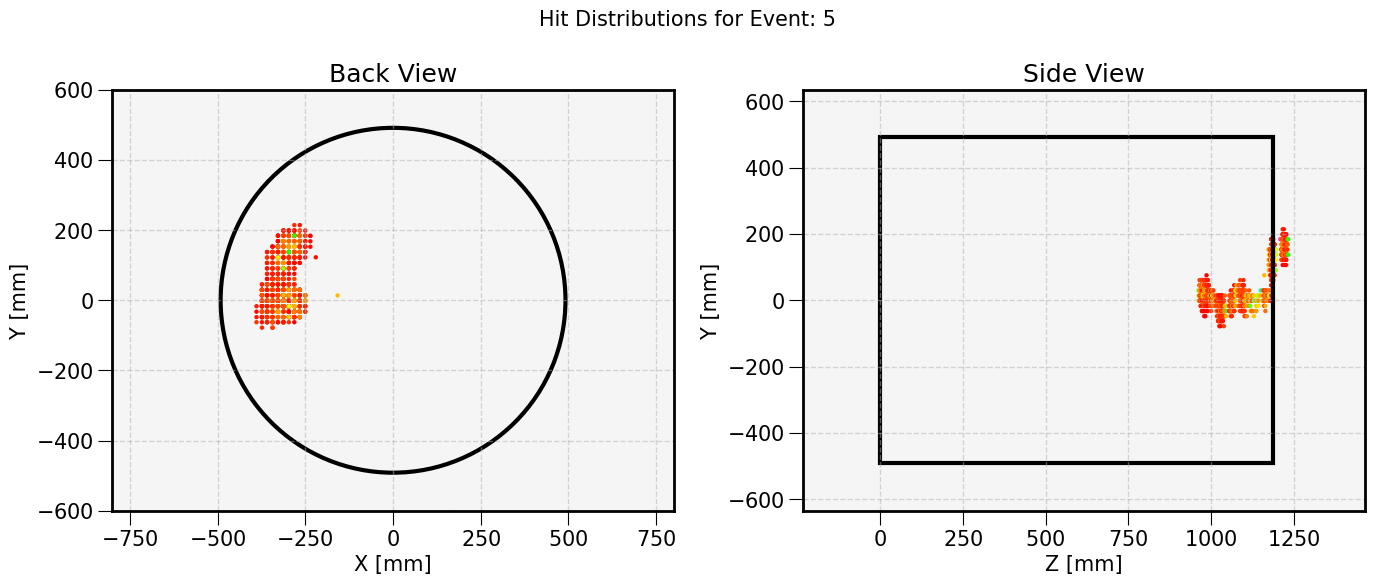

In [24]:
pt.event_display(final_soph_df, variable='Ec', event_column='global_event', event=5)

Update dataframes and counts!

In [10]:
# Add region tags to both dataframes
final_mc_df['region'] = event_region_tags.values
final_soph_df         = final_soph_df.merge(final_mc_df[['global_event', 'region']], on='global_event', how='left')

# Event counts by particle and region
detector_region_counts = final_mc_df.groupby(['region'])['global_event'].nunique()
for region in ['fiducial', 'tube', 'cathode', 'anode']:
    reg_events = detector_region_counts.get(region, 0)
    print(f'{region.capitalize()} = {reg_events} events ({reg_events/len(events_after_trg2):.2%})')

Fiducial = 162683 events (35.66%)
Tube = 211670 events (46.39%)
Cathode = 60807 events (13.33%)
Anode = 21109 events (4.63%)


## Output

Let's store the final dataframe as an HDF5 file

In [ ]:
# 4. OUTPUT
print("\n----- Saving output files")
# npeak column in run_event_df is uint64, convert to int64
for col in final_mc_df.select_dtypes(include=['uint64']).columns:
    final_mc_df[col] = final_mc_df[col].astype('int64')
# Combine all processed dataframes into one
output_filepath = os.path.join(OUTPUT_DIR, OUTPUT_H5)
print(f"Opening HDF5 store for writing: {output_filepath}")
try:
    with pd.HDFStore(output_filepath, mode='w') as store:
        if not final_mc_df.empty:
            store.put('Events', final_mc_df, format='table', data_columns=True)
        # NOTE: Do not store Sophronia file for All MC files
        # if not final_soph_df.empty:
        #     store.put('Hits', final_soph_df, format='table', data_columns=True)
    print("HDF5 saving complete.")
except Exception as e:
    print(f"   Error writing to HDF5 file: {e}", file=sys.stderr)


----- Saving output files
Opening HDF5 store for writing: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/processed_MC_background_All_01122025.h5


# Spectrums

In [33]:
REGIONS = ['Inclusive', 'Fiducial', 'Tube', 'Anode', 'Cathode']

## $Z$ Distribution

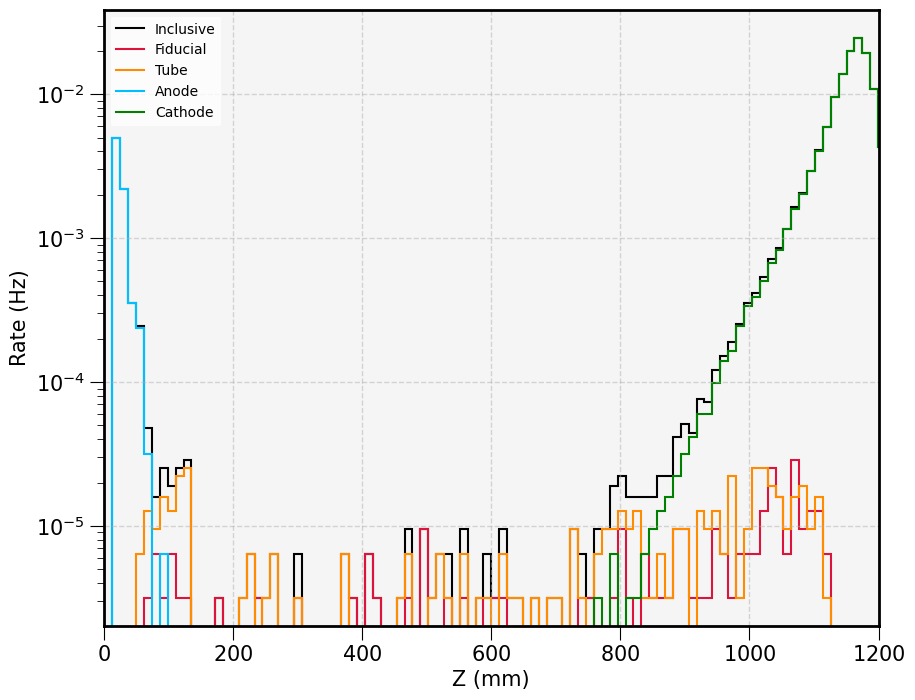

In [34]:
# Global
n_bins = 100

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, Z_edges = np.histogram(mc_all['Z'], bins=n_bins)

for i, region in enumerate(REGIONS):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    Z = mc_region['Z']

    # Histogram
    Z_counts, _ = np.histogram(Z, bins=Z_edges)
    Z_rate = Z_counts / selected_mc_df['Run_time']

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=region, 
               fill=False, lw=1.5, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# ----- Styling ----- #
plt.xlabel('Z (mm)')
plt.xlim(0, 1200)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=10)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## $E$ Distribution

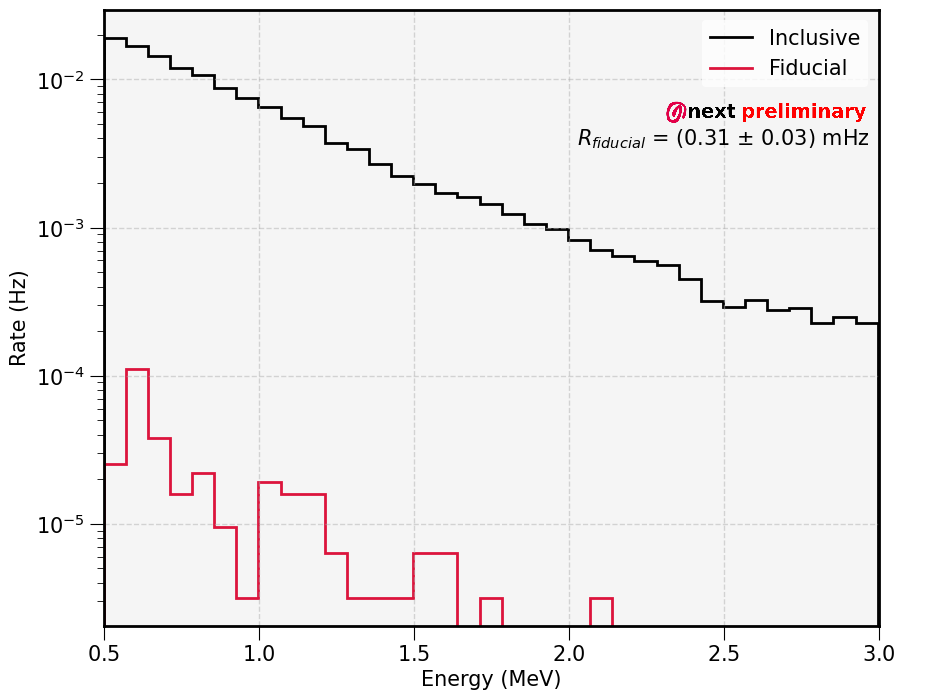

In [35]:
# Global
n_bins = 35

fig, ax = plt.subplots()

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, E_edges = np.histogram(mc_all['E_corr'], bins=n_bins)

for i, region in enumerate(['Inclusive', 'Fiducial']):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    E = mc_region['E_corr']

    # Histogram
    E_counts, _ = np.histogram(E, bins=E_edges)
    E_rate = E_counts / selected_mc_df['Run_time']

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=region, 
               fill=False, ec=pt.hist_colors[i % len(pt.hist_colors)], lw=2.0)
    
# plt.axvline(x=1.59, c='grey', ls='--', lw=1.0)        # DEP
    
# ----- Styling ----- #
# Important text
plt.text(2.50, 4e-3, r'$R_{fiducial}$'f' = ({RATE_CV*1e3:.2f} ± {RATE_ERR*1e3:.2f}) mHz', va='center', ha='center')

# Preliminary logo
LOGO_BOX    = OffsetImage(PRELIM_LOGO, zoom = 0.1)
xy = (2.65, 6e-3)
ab = AnnotationBbox(LOGO_BOX, xy, xybox=(0, 0), xycoords='data', boxcoords="offset points",  frameon=False)
ax.add_artist(ab)

plt.xlabel('Energy (MeV)')
plt.xlim(TRG2_THRESHOLD, ENERGY_THRESHOLD)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend()

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Bi_Fiducial.pdf')
plt.show()

# ROI & Background Index

In [60]:
# ROI definition
ROI_MIN = 2.4; ROI_MAX = 2.5    # in [MeV]

# Fiducial dataframe
Fiducial_df = selected_mc_df['Electron']['Fiducial']

# Events in the ROI
ROI_mask = (Fiducial_df['E_corr'] >= ROI_MIN) & (Fiducial_df['E_corr'] <= ROI_MAX)
ROI_ids  = Fiducial_df.loc[ROI_mask, 'global_event'].unique()
print(f"Found {len(ROI_ids)} events in the ROI [{ROI_MIN}, {ROI_MAX}] MeV")

# Rate in the ROI
evts_CV, evts_var = scipy.stats.binom.stats(n=GENERATED_EVTS, p=len(ROI_ids)/GENERATED_EVTS, moments='mv')
print(f"Events in the ROI = ({int(evts_CV)} ± {np.sqrt(evts_var):.0f}) events")

ROI_rate_CV = evts_CV / selected_mc_df['Run_time']            # in [Hz]
ROI_err_CV  = np.sqrt(evts_var) / selected_mc_df['Run_time']  # in [Hz]
print(f"Rate in the ROI = ({ROI_rate_CV} ± {ROI_err_CV}) Hz")

Found 23 events in the ROI [2.4, 2.5] MeV
Events in the ROI = (23 ± 5) events
Rate in the ROI = (7.293252156265855e-08 ± 1.5207027743095953e-08) Hz


### Fiducial Mass

In [59]:
volume_fid_CV, _ = pt.selection_volume(Z_UP - Z_LOW, 1, R_UP, 1)            # in mm3 - DO NOT USE THIS ERROR
volume_fid_CV /= 1e9                                                        # in m3
temp     = 293.15       # in K
pressure = 3.95         # in bar
R_gas    = 8.3145e-5    # in m3·bar/(K·mol)

# Use PV = nRT to calculate the number of moles
n_moles = (pressure * volume_fid_CV) / (R_gas * temp)    # in mol
print(f"Fiducial - number of moles = {n_moles} mol")
# Xenon molar mass
molar_mass_Xe = 135.9072    # in g/mol
mass_fid_CV = n_moles * molar_mass_Xe / 1e3    # in kg
print(f"Fiducial - mass = {mass_fid_CV} kg")

Fiducial - number of moles = 114.9668367548998 mol
Fiducial - mass = 15.624820876215518 kg
